Thi is a replication package for the ICSR18 paper: 

# An Empirical Analysis of Technical Lag in npm Package Dependencies

In [1]:
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('ggplot')
import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import math

sns.set_style('whitegrid')
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 42}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.labelsize']= 28
plt.rcParams['lines.linewidth']= 2
plt.rcParams['lines.markersize']= 2

In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d)+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    print(lst2,cliffsDelta(lst1,lst2)) # should return False

# Loading data as dataframes

Outdates dependencies: tLag dataframe

In [3]:
dev_per_outdated=pd.read_csv('../icsr2018/csv/outdated_deps-20-11.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

dev_per_outdated['dependency_date']=dev_per_outdated['dependency_date'].apply(lambda x: str(x).split()[0])
dev_per_outdated['latest_dependency_release']=dev_per_outdated['latest_dependency_release'].apply(lambda x: str(x).split()[0])

dev_per_outdated['dependency_date']=pd.to_datetime(dev_per_outdated['dependency_date'])
dev_per_outdated['latest_dependency_release']=pd.to_datetime(dev_per_outdated['latest_dependency_release'])
dev_per_outdated['time']=dev_per_outdated['latest_dependency_release']- dev_per_outdated['dependency_date']
dev_per_outdated['dependency_kind']=dev_per_outdated['dependency_kind'].apply(lambda x: x.capitalize())
dev_per_outdated=dev_per_outdated.query('dependency_kind=="Development" or dependency_kind=="Runtime"')
dev_per_outdated.head(1)

,dependency,package,package.1,version_date,dependency_constraint,dependency_kind,dependency_version,dependency_date,latest_dependency_release,type,time
0,zygon,ood,ood,2016-02-08 00:17:23 UTC,^0.0.4,Runtime,0.0.4,2016-01-28,2016-01-30,caret,2 days


Package updates dataframe:

In [14]:
tech_lag_calcul=pd.read_csv('../icsr2018/csv/tech_lag_updates-16-11.csv', sep=';', dtype=object, index_col=None)

tech_lag_calcul['release_type']=tech_lag_calcul['major_release']+';'+tech_lag_calcul['minor_release']+';'+tech_lag_calcul['patch_release']

tech_lag_calcul['release_type']=tech_lag_calcul['release_type'].apply(lambda x: 'Major release' if str(x).split(';')[0]!="False"
                                                     else 'Minor release' if str(x).split(';')[1]!="False"
                                                     else 'Patch release' if str(x).split(';')[2]!="False"
                                                     else 'First release')
tech_lag_calcul['release_type']=tech_lag_calcul['release_type'].apply(lambda x: x.capitalize())

tech_lag_calcul['updates']=tech_lag_calcul['updates'].apply(int)
tech_lag_calcul['updates_inverse']=tech_lag_calcul['updates_inverse'].apply(int)

tech_lag_calcul['updates_cumsum']=tech_lag_calcul['updates'].cumsum()
tech_lag_calcul['updates_inverse_cumsum']=tech_lag_calcul['updates_inverse'].cumsum()

tech_lag_calcul.head(1)

,package,version,date,major_release,minor_release,patch_release,added,removed,stayed,updated_major,updated_minor,updated_patch,updates,updates_inverse,updated_constraint,falses,release_type,updates_cumsum,updates_inverse_cumsum
0,@0x5e/react-native-alipay,0.1.0,2017-10-11,False,False,False,1,0,0,0,0,0,0,0,0,0,First release,0,0


Outdates dependencies: vLag dataframe

In [15]:
lag_versions=pd.read_csv('../icsr2018/csv/lag_versions_01-12.csv', sep=';', dtype=object, index_col=None, error_bad_lines=False)

lag_versions['date_len']=lag_versions['version_date'].apply(lambda x: len(str(x).split('-')))
lag_versions=lag_versions.query('date_len!=1')
lag_versions['date']=lag_versions['version_date'].apply(lambda x: str(x).split('-')[0])
lag_versions.head(1)

b'Skipping line 2969316: expected 11 fields, saw 18\n'


,package,version_date,dependency,dependency_kind,dependency_constraint,dependency_version,dependency_date,latest_date,major_lag,minor_lag,patch_lag,date_len,date
0,@~lisfan/logger,2017-10-20 07:14:23 UTC,@~lisfan/validation,runtime,^1.0.0-rc.8,1.0.0-rc.8,2017-10-20 07:12:51 UTC,2017-10-20 07:14:06 UTC,0,0,1,3,2017


Outdated vs Not outdated:

In [16]:
outies=pd.read_csv('../icsr2018/csv/outdated_and_not.csv', sep=';', index_col=None)
outies["outdated2"]=outies["outdated2"].apply(lambda x: x.capitalize())
outies=outies.rename(columns ={'versions per year':'Versions per year','version in lifetime':'Versions in lifetime'})
#print(len(outies.query('outdated == True')), len(outies.query('outdated == False')))
outies.head(1)

,outdated_packages,outdated_versions,used_packages,used_versions,version,outdated,date,verOndate,date2,Versions per year,Versions in lifetime,outdated2,versions in lifetime
0,NaN,NaN,10.0,255.0,1.0,False,1332,0.274024,3.649315,0.274024,1.0,Not outdated,1.0


# Analysis begins

Technical lag example: eslint

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


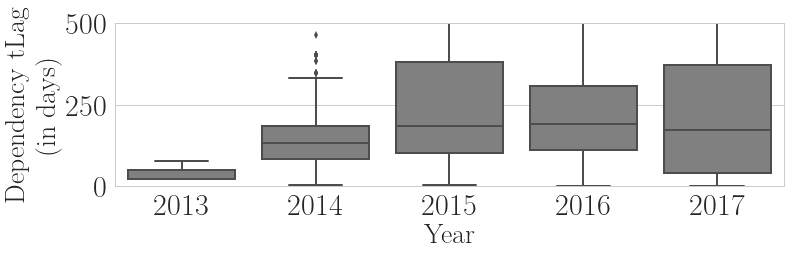

In [17]:
dev_per_outdated_eslint=dev_per_outdated.query('package=="eslint"')
dev_per_outdated_eslint['date']=dev_per_outdated_eslint['version_date'].apply(lambda x: str(x).split()[0].split('-')[0])
outdated_time=dev_per_outdated_eslint.loc[:,['time','date']]
outdated_time['time']=outdated_time['time'].apply(lambda x: int(str(x).split()[0]))

#start ploting
ax = sns.boxplot(y="time", x='date', color='gray', data=outdated_time, order=['2013','2014','2015','2016','2017'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Dependency tLag \n (in days)')
ax.set_xlabel('Year')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,500)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=18,ncol=3, fancybox=True, shadow=True)


(0, 7)

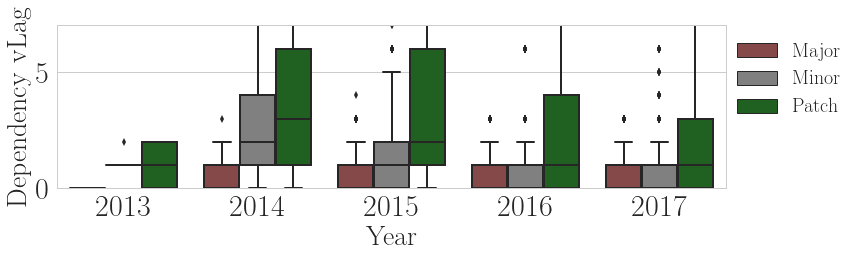

In [18]:
la_ver=lag_versions.query('package=="eslint"').loc[:,['date','major_lag','minor_lag','patch_lag']]
la_ver=la_ver.rename(columns = {'major_lag':'Major','patch_lag':'Patch', 'minor_lag':'Minor'})
la_ver2=pd.melt(la_ver, id_vars=['date'])#, value_vars=['updated to major','updated to minor','updated to patch'])
la_ver2=la_ver2.rename(columns = {'variable':'version type', 'value':'vLag'})
la_ver2['vLag']=la_ver2['vLag'].apply(int)
la_ver2=la_ver2.sort_values(['date'], ascending=True)

#start plotting
ax = sns.boxplot(y="vLag", x="date", hue="version type", hue_order=['Major','Minor','Patch'], data=la_ver2, palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Dependency vLag')
ax.set_xlabel('Year')
ax.figure.set_size_inches(12,3)
ax.legend( loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
ax.set_ylim(0,7)

# RQ0: How do packages manage their dependencies?

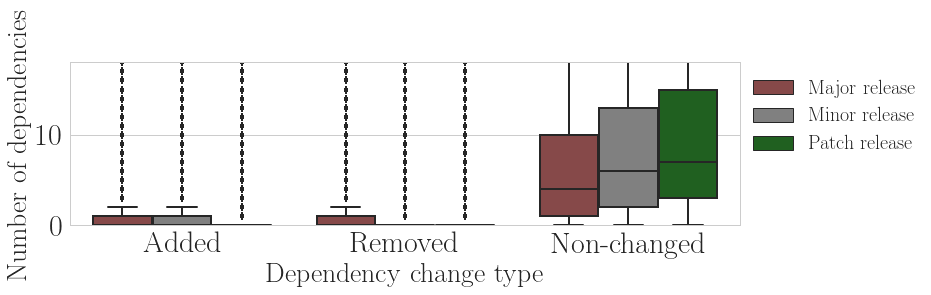

In [22]:
updates=tech_lag_calcul.loc[:,['release_type','added','stayed','removed']]
updates['Added']=updates['added'].apply(float)
updates['Non-changed']=updates['stayed'].apply(float)
updates['Removed']=updates['removed'].apply(float)
updates=updates.query('release_type!="first release"')
updates=updates.loc[:,['Added','Removed','Non-changed','release_type']]

updates_2=pd.melt(updates, id_vars=['release_type'], value_vars=['Added','Removed','Non-changed'])
updates_2=updates_2.rename(columns = {'variable':'deps'})

# Start plotting
ax = sns.boxplot(y="value", x="deps", hue="release_type", data=updates_2, hue_order=['Major release','Minor release','Patch release'], palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Number of dependencies')
ax.set_xlabel('Dependency change type')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,18)
ax.legend( loc='upper right', bbox_to_anchor=(1.29, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)

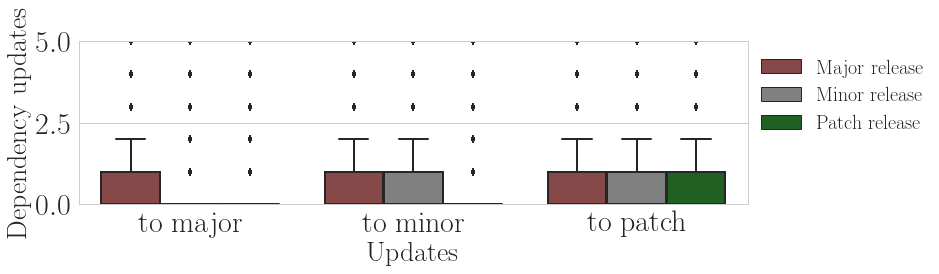

In [23]:
updates=tech_lag_calcul.loc[:,['release_type','updated_major','updated_minor','updated_patch']]
updates['updated_major']=updates['updated_major'].apply(float)
updates['updated_minor']=updates['updated_minor'].apply(float)
updates['updated_patch']=updates['updated_patch'].apply(float)
updates=updates.query('release_type!="first release"')
updates=updates.loc[:,['updated_major','updated_minor','updated_patch','release_type']]

updates2=updates.rename(columns = {'updated_major':'to major','updated_minor':'to minor', 'updated_patch':'to patch'})
updates_2=pd.melt(updates2, id_vars=['release_type'], value_vars=['to major','to minor','to patch'])
updates_2=updates_2.rename(columns = {'variable':'updates'})

#start plotting
ax = sns.boxplot(y="value", x="updates", hue="release_type", data=updates_2, hue_order=['Major release','Minor release','Patch release'], palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Dependency updates')
ax.set_xlabel('Updates')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,5)
ax.legend( loc='upper right', bbox_to_anchor=(1.29, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)

# RQ1: How often do packages release new versions?

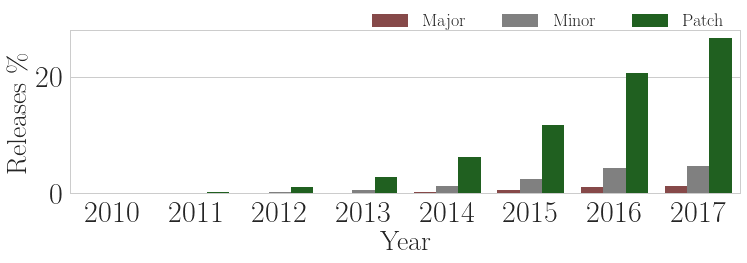

In [24]:
updates=tech_lag_calcul.query('release_type!="first release"')
updates['datee']=updates['date'].apply(lambda x: str(x).split('-')[0])
updates['type']=updates['release_type'].apply(lambda x: str(x).split()[0])
a=updates.groupby(['type','datee']).count().reset_index()
a.sort_values(['package'], ascending=False, inplace=True)
a['package']=a['package'].apply(lambda x: float(x)*100/float(len(updates)))

#start ploting
ax = sns.barplot(x="datee", y="package", hue="type", data=a, hue_order=['Major','Minor','Patch'], palette=['brown','gray','green'], saturation=0.5 )
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Year')
ax.set_ylabel('Releases \%')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=18,ncol=3, fancybox=True, shadow=True)


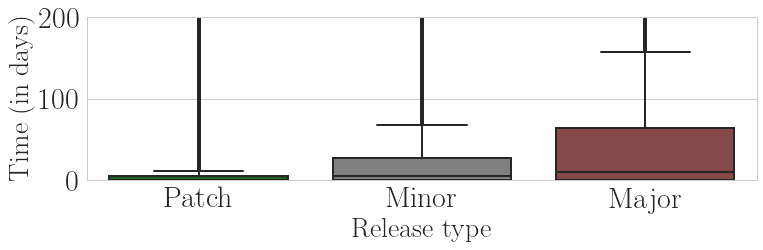

In [25]:
updates=tech_lag_calcul.loc[:,['release_type','major_release','minor_release','patch_release','date']]
updates=updates.query('release_type!="First release"')
updates['release_type']=updates['major_release']+';'+updates['minor_release']+';'+updates['patch_release']
#updates=updates.query('updated_major != 0 or updated_minor != 0 or updated_patch != 0')
updates['time']=updates['release_type'].apply(lambda x: str(x).split(';')[0] if str(x).split(';')[0]!="False"
                                                     else str(x).split(';')[1] if str(x).split(';')[1]!="False"
                                                     else str(x).split(';')[2])
updates['time before releasing']=updates['time'].apply(float)
updates['release_type']=updates['release_type'].apply(lambda x: 'Major' if str(x).split(';')[0]!="False"
                                                     else 'Minor' if str(x).split(';')[1]!="False"
                                                     else 'Patch')
updates['date']=updates['date'].apply(lambda x : str(x).split('-')[0])
updates=updates.loc[:,['time before releasing','release_type','date']]

updates_2=updates
#updates_2=updates_2.rename(columns = {'variable':'deps'})

#start plotting
ax = sns.boxplot(y="time before releasing", x="release_type", data=updates_2, order=['Patch','Minor','Major'], palette=['green','gray','brown','blue'], saturation=0.5)#, split=True)#, order=order)    
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,200)
ax.set_ylabel('Time (in days)')
ax.set_xlabel('Release type')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=18,ncol=3, fancybox=True, shadow=True)

# RQ2: What is the technical lag induced by outdated packages?

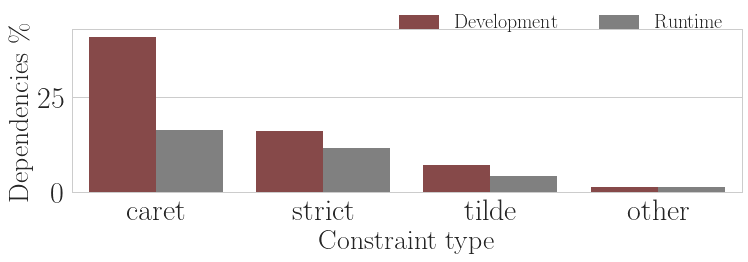

In [30]:
a=dev_per_outdated
a=a.groupby(['type','dependency_kind']).count().reset_index()
a['kind']=a['dependency_kind']
a.sort_values(['dependency'], ascending=False, inplace=True)
a['package']=a['dependency'].apply(lambda x: float(x)*100/float(len(dev_per_outdated)))

ax = sns.barplot(x="type", y="package", hue="kind", data=a, palette=['brown','gray','green'], saturation=0.5 )
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=20,ncol=3)#, fancybox=True, shadow=True)

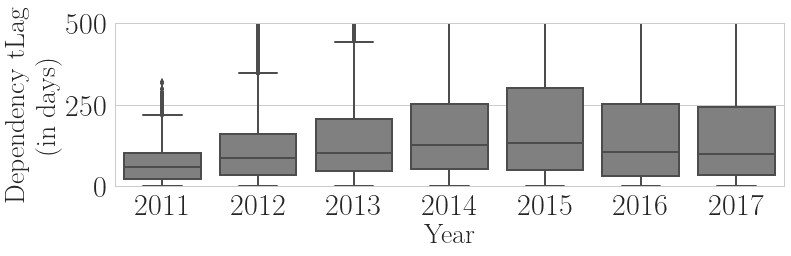

In [29]:
outdated_time=dev_per_outdated.loc[:,['time','version_date']]
outdated_time['date']=outdated_time['version_date'].apply(lambda x: str(x).split()[0].split('-')[0])
outdated_time['time']=outdated_time['time'].apply(lambda x: int(str(x).split()[0]))

ax = sns.boxplot(y="time", x='date', color='gray', data=outdated_time, order=['2011','2012','2013','2014','2015','2016','2017'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Dependency tLag \n (in days)')
ax.set_xlabel('Year')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,500)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=18,ncol=3, fancybox=True, shadow=True)

(0, 8)

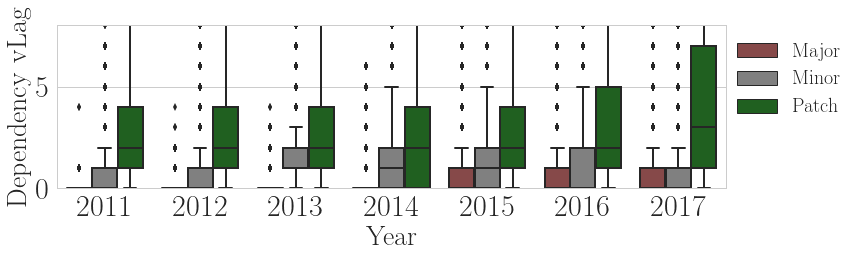

In [31]:
la_ver=lag_versions.loc[:,['date','major_lag','minor_lag','patch_lag']]
la_ver=la_ver.rename(columns = {'major_lag':'Major','patch_lag':'Patch', 'minor_lag':'Minor'})
la_ver2=pd.melt(la_ver, id_vars=['date'])#, value_vars=['updated to major','updated to minor','updated to patch'])
la_ver2=la_ver2.rename(columns = {'variable':'version type', 'value':'vLag'})
la_ver2['vLag']=la_ver2['vLag'].apply(int)

ax = sns.boxplot(y="vLag", x="date", hue="version type", data=la_ver2, order=['2011','2012','2013','2014','2015','2016','2017'], palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Dependency vLag')
ax.set_xlabel('Year')
ax.figure.set_size_inches(12,3)
ax.legend( loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
ax.set_ylim(0,8)

In [40]:
scipy.stats.normaltest(la_ver2[la_ver2['version type']=="Patch"].query('date=="2017"').vLag)

NormaltestResult(statistic=11805141.029211298, pvalue=0.0)

In [38]:
cliffsDelta(la_ver2[la_ver2['version type']=="Patch"].query('date=="2017"').vLag,
                         la_ver2[la_ver2['version type']=="Patch"].query('date=="2016"').vLag)

d=0.1579291019840121 True


True

In [39]:
scipy.stats.mannwhitneyu(la_ver2[la_ver2['version type']=="Patch"].query('date=="2017"').vLag,
                         la_ver2[la_ver2['version type']=="Patch"].query('date=="2014"').vLag,
                        use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=2378047783470.0, pvalue=0.0)

# RQ3: How often do dependencies inducing technical lag release new versions?

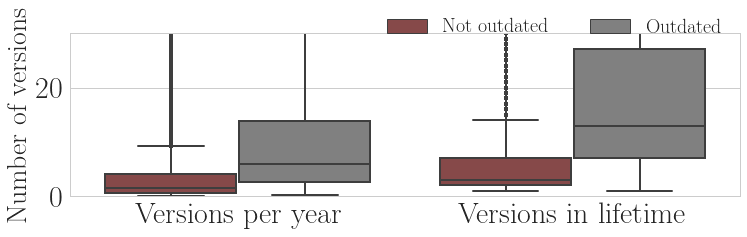

In [32]:
deps_out2_melted=pd.melt(outies, id_vars=['outdated2'], value_vars=['Versions per year','Versions in lifetime'])
ax = sns.boxplot(y="value", x="variable", hue="outdated2", data=deps_out2_melted, palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)
ax.figure.set_size_inches(12,3)
ax.set_ylim(0,30)
ax.set_ylabel('Number of versions')
ax.set_xlabel('')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=20,ncol=3)#, fancybox=True, shadow=True)

In [36]:
outies['vYear']=outies['Versions per year']
outies['vLife']=outies['Versions in lifetime']
outies.query('outdated==True').vYear.describe().apply(lambda x: format(x, 'f'))

count    34897.000000
mean        15.242536
std         47.481980
min          0.197832
25%          2.678197
50%          5.868167
75%         13.750000
max       1555.858586
Name: vYear, dtype: object

In [37]:
cliffsDelta(outies.query('outdated==True').vLife,outies.query('outdated==False').vLife)

d=0.650112131609569 True


True

# RQ4:What is the appropriate moment to update dependencies?

(0, 20)

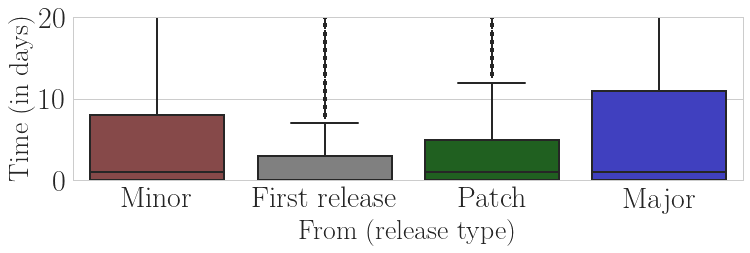

In [33]:
tech_lag_calcul2=pd.read_csv('../icsr2018/csv/tech_lag_updates-16-11.csv', sep=';', dtype=object, index_col=None)
len(tech_lag_calcul2)
tech_lag_calcul2['release_type']=tech_lag_calcul2['major_release']+';'+tech_lag_calcul2['minor_release']+';'+tech_lag_calcul2['patch_release']

tech_lag_calcul2['release_type']=tech_lag_calcul2['release_type'].apply(lambda x: 'Major' if str(x).split(';')[0]!="False"
                                                     else 'Minor' if str(x).split(';')[1]!="False"
                                                     else 'Patch' if str(x).split(';')[2]!="False"
                                                     else 'First release')


index_release_type=tech_lag_calcul2.loc[:,['release_type','package']]
index_release_type=index_release_type.rename(columns = {'release_type':'release_type_before','package':'package_before'})

index_release_type.index = index_release_type.index + 1  # shifting index
index_release_type=pd.concat([tech_lag_calcul2, index_release_type], axis=1)

index_release_patch=index_release_type.query('release_type=="Patch"')

index_release_patch=index_release_patch.loc[:,['package','date','patch_release','release_type_before']]
index_release_patch['time']=index_release_patch['patch_release'].apply(int)
index_release_patch['from']=index_release_patch['release_type_before']

#start ploting
ax = sns.boxplot(y="time", x="from", data=index_release_patch, palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('Time (in days)')
ax.set_xlabel('From (release type)')

ax.figure.set_size_inches(12,3)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3)#, fancybox=True, shadow=True)
ax.set_ylim(0,20)

In [41]:
scipy.stats.ranksums(index_release_patch[index_release_patch['from']=="Minor"].time,
                     index_release_patch[index_release_patch['from']=="Major"].time)

RanksumsResult(statistic=-6.6959158550185309, pvalue=2.1432502878800871e-11)